This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/pose.html).  I recommend having both windows open, side-by-side!

In [1]:
from functools import partial

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display
from pydrake.all import (
    CsdpSolver,
    MathematicalProgram,
    RigidTransform,
    RotationMatrix,
    Solve,
    ge,
)
from scipy.spatial import KDTree

from manipulation import running_as_notebook

if running_as_notebook:
    mpld3.enable_notebook()

# Point cloud registration with known correspondences

True position: [1.05407166 0.66218056 0.        ]
True orientation: AngleAxis(angle=0.4880489428993765, axis=[0. 0. 1.])
Estimated position: [1.05407166 0.66218056 0.        ]
Estimated orientation: AngleAxis(angle=0.4880489428993764, axis=[0. 0. 1.])


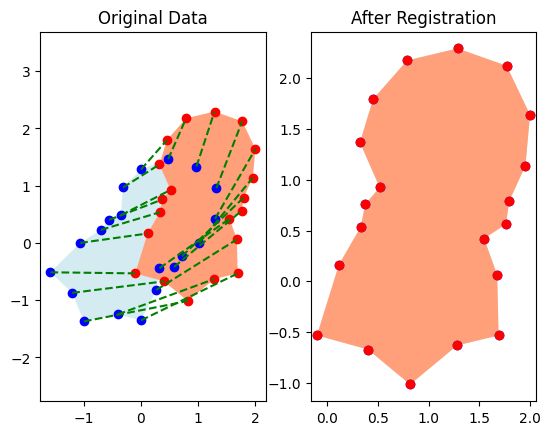

In [2]:
def MakeRandomObjectModelAndScenePoints(
    num_model_points=20,
    noise_std=0,
    num_outliers=0,
    yaw_O=None,
    p_O=None,
    num_viewable_points=None,
    seed=None,
):
    """Returns p_Om, p_s"""
    rng = np.random.default_rng(seed)

    # Make a random set of points to define our object in the x,y plane
    theta = np.arange(0, 2.0 * np.pi, 2.0 * np.pi / num_model_points)
    l = 1.0 + 0.5 * np.sin(2.0 * theta) + 0.4 * rng.random((1, num_model_points))
    p_Om = np.vstack((l * np.sin(theta), l * np.cos(theta), 0 * l))

    # Make a random object pose if one is not specified, and apply it to get the scene points.
    if p_O is None:
        p_O = [2.0 * rng.random(), 2.0 * rng.random(), 0.0]
    if len(p_O) == 2:
        p_O.append(0.0)
    if yaw_O is None:
        yaw_O = 0.5 * rng.random()
    X_O = RigidTransform(RotationMatrix.MakeZRotation(yaw_O), p_O)
    if num_viewable_points is None:
        num_viewable_points = num_model_points
    assert num_viewable_points <= num_model_points
    p_s = X_O.multiply(p_Om[:, :num_viewable_points])
    p_s[:2, :] += rng.normal(scale=noise_std, size=(2, num_viewable_points))
    if num_outliers:
        outliers = rng.uniform(low=-1.5, high=3.5, size=(3, num_outliers))
        outliers[2, :] = 0
        p_s = np.hstack((p_s, outliers))

    return p_Om, p_s, X_O


def MakeRectangleModelAndScenePoints(
    num_points_per_side=7,
    noise_std=0,
    num_outliers=0,
    yaw_O=None,
    p_O=None,
    num_viewable_points=None,
    seed=None,
):
    rng = np.random.default_rng(seed)
    if p_O is None:
        p_O = [2.0 * rng.random(), 2.0 * rng.random(), 0.0]
    if len(p_O) == 2:
        p_O.append(0.0)
    if yaw_O is None:
        yaw_O = 0.5 * rng.random()
    X_O = RigidTransform(RotationMatrix.MakeZRotation(yaw_O), p_O)
    if num_viewable_points is None:
        num_viewable_points = 4 * num_points_per_side

    x = np.arange(-1, 1, 2 / num_points_per_side)
    half_width = 2
    half_height = 1
    top = np.vstack((half_width * x, half_height + 0 * x))
    right = np.vstack((half_width + 0 * x, -half_height * x))
    bottom = np.vstack((-half_width * x, -half_height + 0 * x))
    left = np.vstack((-half_width + 0 * x, half_height * x))
    p_Om = np.vstack(
        (
            np.hstack((top, right, bottom, left)),
            np.zeros((1, 4 * num_points_per_side)),
        )
    )
    p_s = X_O.multiply(p_Om[:, :num_viewable_points])
    p_s[:2, :] += rng.normal(scale=noise_std, size=(2, num_viewable_points))
    if num_outliers:
        outliers = rng.uniform(low=-1.5, high=3.5, size=(3, num_outliers))
        outliers[2, :] = 0
        p_s = np.hstack((p_s, outliers))

    return p_Om, p_s, X_O


def PlotEstimate(p_Om, p_s, Xhat_O=RigidTransform(), chat=None, X_O=None, ax=None):
    p_m = Xhat_O.multiply(p_Om)
    if ax is None:
        ax = plt.subplot()
    Nm = p_Om.shape[1]
    artists = ax.plot(p_m[0, :], p_m[1, :], "bo")
    artists += ax.fill(p_m[0, :], p_m[1, :], "lightblue", alpha=0.5)
    artists += ax.plot(p_s[0, :], p_s[1, :], "ro")
    if chat is not None:
        artists += ax.plot(
            np.vstack((p_m[0, chat], p_s[0, :])),
            np.vstack((p_m[1, chat], p_s[1, :])),
            "g--",
        )
    if X_O:
        p_s = X_O.multiply(p_Om)
    artists += ax.fill(p_s[0, :Nm], p_s[1, :Nm], "lightsalmon")
    ax.axis("equal")
    return artists


def PrintResults(X_O, Xhat_O):
    p = X_O.translation()
    aa = X_O.rotation().ToAngleAxis()
    print(f"True position: {p}")
    print(f"True orientation: {aa}")
    p = Xhat_O.translation()
    aa = Xhat_O.rotation().ToAngleAxis()
    print(f"Estimated position: {p}")
    print(f"Estimated orientation: {aa}")


def PoseEstimationGivenCorrespondences(p_Om, p_s, chat):
    """Returns optimal X_O given the correspondences"""
    # Apply correspondences, and transpose data to support numpy broadcasting
    p_Omc = p_Om[:, chat].T
    p_s = p_s.T

    # Calculate the central points
    p_Ombar = p_Omc.mean(axis=0)
    p_sbar = p_s.mean(axis=0)

    # Calculate the "error" terms, and form the data matrix
    merr = p_Omc - p_Ombar
    serr = p_s - p_sbar
    W = np.matmul(serr.T, merr)

    # Compute R
    U, Sigma, Vt = np.linalg.svd(W)
    R = np.matmul(U, Vt)
    if np.linalg.det(R) < 0:
        print("fixing improper rotation")
        Vt[-1, :] *= -1
        R = np.matmul(U, Vt)

    # Compute p
    p = p_sbar - np.matmul(R, p_Ombar)

    return RigidTransform(RotationMatrix(R), p)


p_Om, p_s, X_O = MakeRandomObjectModelAndScenePoints(num_model_points=20)
# p_Om, p_s, X_O = MakeRectangleModelAndScenePoints()
Xhat = RigidTransform()
c = range(p_Om.shape[1])  # perfect, known correspondences
fig, ax = plt.subplots(1, 2)
PlotEstimate(p_Om, p_s, Xhat, c, ax=ax[0])
Xhat = PoseEstimationGivenCorrespondences(p_Om, p_s, c)
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
PlotEstimate(p_Om, p_s, Xhat, c, ax=ax[1])
ax[0].set_title("Original Data")
ax[1].set_title("After Registration")
PrintResults(X_O, Xhat)

# Iterative Closest Point (ICP)

In [ ]:
def FindClosestPoints(point_cloud_A, point_cloud_B):
    """
    Finds the nearest (Euclidean) neighbor in point_cloud_B for each
    point in point_cloud_A.
    @param point_cloud_A A 3xN numpy array of points.
    @param point_cloud_B A 3xN numpy array of points.
    @return indices An (N, ) numpy array of the indices in point_cloud_B of each
        point_cloud_A point's nearest neighbor.
    """
    indices = np.empty(point_cloud_A.shape[1], dtype=int)

    kdtree = KDTree(point_cloud_B.T)
    for i in range(point_cloud_A.shape[1]):
        distance, indices[i] = kdtree.query(point_cloud_A[:, i], k=1)

    return indices


def IterativeClosestPoint(p_Om, p_s, X_O=None, animate=True):
    Xhat = RigidTransform()
    Nm = p_s.shape[1]
    chat_previous = (
        np.zeros(Nm) - 1
    )  # Set chat to a value that FindClosePoints will never return.

    if animate:
        fig, ax = plt.subplots()
        frames = []
        frames.append(
            PlotEstimate(p_Om=p_Om, p_s=p_s, Xhat_O=Xhat, chat=None, X_O=X_O, ax=ax)
        )

    while True:
        chat = FindClosestPoints(p_s, Xhat.multiply(p_Om))
        if np.array_equal(chat, chat_previous):
            # Then I've converged.
            break
        chat_previous = chat
        if animate:
            frames.append(
                PlotEstimate(p_Om=p_Om, p_s=p_s, Xhat_O=Xhat, chat=chat, X_O=X_O, ax=ax)
            )
        Xhat = PoseEstimationGivenCorrespondences(p_Om, p_s, chat)
        if animate:
            frames.append(
                PlotEstimate(p_Om=p_Om, p_s=p_s, Xhat_O=Xhat, chat=None, X_O=X_O, ax=ax)
            )

    if animate:
        ani = animation.ArtistAnimation(fig, frames, interval=400, repeat=False)

        display(HTML(ani.to_jshtml()))
        plt.close()

    if X_O:
        PrintResults(X_O, Xhat)

    return Xhat, chat


p_Om, p_s, X_O = MakeRandomObjectModelAndScenePoints(num_model_points=20)
IterativeClosestPoint(p_Om, p_s, X_O);

Try increasing the standard deviation on yaw in the example above.  At some point, the performance can get pretty poor!

# ICP with messy point clouds

Try changing the amount of noise, the number of outliers, and/or the partial views.  There are not particularly good theorems here, but I hope that a little bit of play will get you a lot of intuition.

In [ ]:
p_Om, p_s, X_O = MakeRectangleModelAndScenePoints(
    #    noise_std=0.2, # adds noise to each scene point (default is 0.0)
    #    num_outliers=3, # adds random points from a uniform distribution
    #    num_viewable_points=9, # only this number of model points appear in the scene points
    yaw_O=0.2,  # object orientation (comment it out for random rotations)
    p_O=[1, 2],  # object position (comment it out for random positions)
)
IterativeClosestPoint(p_Om, p_s, X_O);

## Is least-squares the right cost function?

Here is a particular setup that is interesting.  The configuration I've given you below results in ICP getting stuck in a local minima.  You will find that the system converges to this local minima from a wide variety of initial conditions.

In [ ]:
p_Om, p_s, X_O = MakeRectangleModelAndScenePoints(
    num_viewable_points=9,
    yaw_O=0.2,
    p_O=[1, 2],
)
IterativeClosestPoint(p_Om, p_s, X_O);

# Non-penetration constraints with nonlinear optimization

In [ ]:
def ConstrainedKnownCorrespondenceNonlinearOptimization(p_Om, p_s, chat):
    """This version adds a non-penetration constraint (x,y >= 0)"""

    p_Omc = p_Om[:2, chat]
    p_s = p_s[:2, :]
    Ns = p_s.shape[1]

    prog = MathematicalProgram()
    p = prog.NewContinuousVariables(2, "p")
    theta = prog.NewContinuousVariables(1, "theta")

    def position_model_in_world(vars, i):
        [p, theta] = np.split(vars, [2])
        R = np.array(
            [
                [np.cos(theta[0]), -np.sin(theta[0])],
                [np.sin(theta[0]), np.cos(theta[0])],
            ]
        )
        p_Wmci = p + R @ p_Omc[:, i]
        return p_Wmci

    def squared_distance(vars, i):
        p_Wmci = position_model_in_world(vars, i)
        err = p_Wmci - p_s[:, i]
        return err.dot(err)

    for i in range(Ns):
        # forall i, |p + R*p_Omi - p_si|²
        prog.AddCost(partial(squared_distance, i=i), np.concatenate([p[:], theta]))
        # forall i, p + R*p_Omi >= 0.
        prog.AddConstraint(
            partial(position_model_in_world, i=i),
            vars=np.concatenate([p[:], theta]),
            lb=[0, 0],
            ub=[np.inf, np.inf],
        )

    result = Solve(prog)

    theta_sol = result.GetSolution(theta[0])
    Rsol = np.array(
        [
            [np.cos(theta_sol), -np.sin(theta_sol), 0],
            [np.sin(theta_sol), np.cos(theta_sol), 0],
            [0, 0, 1],
        ]
    )
    psol = np.zeros(3)
    psol[:2] = result.GetSolution(p)

    return RigidTransform(RotationMatrix(Rsol), psol)


p_Om, p_s, X_O = MakeRectangleModelAndScenePoints(
    yaw_O=0.2,
    p_O=[1.5, 1.2],
)
c = range(p_Om.shape[1])  # perfect, known correspondences
Xhat_O = ConstrainedKnownCorrespondenceNonlinearOptimization(p_Om, p_s, c)
PlotEstimate(p_Om=p_Om, p_s=p_s, Xhat_O=Xhat_O, chat=c, X_O=X_O)
PrintResults(X_O, Xhat_O)
plt.gca().plot([0, 0], [0, 2.5], "g-", linewidth=3)
plt.gca().plot([0, 4], [0, 0], "g-", linewidth=3);

# Non-penetration (half-plane) constraints with convex optimization

In [ ]:
def ConstrainedKnownCorrespondenceConvexRelaxation(p_Om, p_s, chat):
    """This version adds a non-penetration constraint (x,y >= 0)"""

    p_Omc = p_Om[:2, chat]
    p_s = p_s[:2, :]
    Ns = p_s.shape[1]

    prog = MathematicalProgram()
    [a, b] = prog.NewContinuousVariables(2)
    # We use the slack variable as an upper bound on the cost of each point to make the objective linear.
    slack = prog.NewContinuousVariables(Ns)
    p = prog.NewContinuousVariables(2)
    prog.AddBoundingBoxConstraint(0, 1, [a, b])  # This makes Csdp happier
    R = np.array([[a, -b], [b, a]])
    prog.AddLorentzConeConstraint([1.0, a, b])

    # Note: Could do this more efficiently, exploiting trace.  But I'm keeping it simpler here.
    prog.AddCost(np.sum(slack))
    for i in range(Ns):
        c = p + np.matmul(R, p_Omc[:, i]) - p_s[:, i]
        # forall i, slack[i]^2 >= |c|^2
        prog.AddLorentzConeConstraint([slack[i], c[0], c[1]])
        # forall i, p + R*mi >= 0.
        prog.AddConstraint(ge(p + np.matmul(R, p_Omc[:, i]), [0, 0]))

    result = CsdpSolver().Solve(prog)

    [a, b] = result.GetSolution([a, b])
    Rsol = np.array([[a, -b, 0], [b, a, 0], [0, 0, 1]])
    psol = np.zeros(3)
    psol[:2] = result.GetSolution(p)

    return RigidTransform(RotationMatrix(Rsol), psol)


p_Om, p_s, X_O = MakeRectangleModelAndScenePoints(
    yaw_O=0.2,
    p_O=[1.5, 1.2],
)
c = range(p_Om.shape[1])  # perfect, known correspondences
Xhat_O = ConstrainedKnownCorrespondenceConvexRelaxation(p_Om, p_s, c)
PlotEstimate(p_Om=p_Om, p_s=p_s, Xhat_O=Xhat_O, chat=c, X_O=X_O)
PrintResults(X_O, Xhat_O)
plt.gca().plot([0, 0], [0, 2.5], "g-", linewidth=3)
plt.gca().plot([0, 4], [0, 0], "g-", linewidth=3);

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ea20f703-e3e0-4399-93f9-5b4dd11062c2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>